# REUNET and Kriging Demo

In [1]:
from REUNET import Reunet
import cv2, torch
from lib import modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kriging import Kriging
from skimage.metrics import mean_squared_error, structural_similarity
from time import perf_counter
np.random.seed(4)
%matplotlib inline

# Load the model from the .pt file.
The model used can be phase = 'secondU' or 'firstU'

Automatically detects of the system is capable of using GPU (CUDA) and uses it. Or else, CPU will be used instead.

In [2]:
model = modules.RadioWNet(inputs=2, phase='secondU')
# model_path = r'Kaggle\results_ATSTACK_firstU_x64\NewRMModel\Trained_Model_firstU_AI_Stack_e750.pt'
model_path = r'Kaggle\results_reboot_secondU_r2_10_100\NewRMModel\Trained_Model_secondU_reboot_flow2_r2_e100.pt'

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

Uncomment the following code to check the model summary

In [3]:
# Uncomment to check the Model Summary

# from torchsummary import summary
# summary(model, input_size=(2,256,256))

# Load up the Ground Truth

Edit the parameters dictionary if necessary.

<AxesSubplot:>

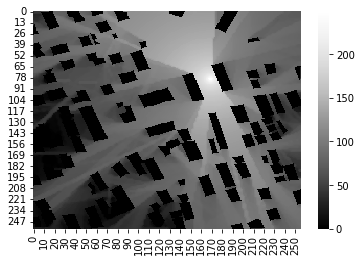

In [4]:
sample = Reunet(model=model)
sample_kriging = Kriging()
folder_paths = {
    'multi' : 'REUNETDataMulti',
    'single' : 'REUNETData',
    'singlex64': 'REUNETData64',
    'singlex128': 'REUNETData128',
}

########################################################
#
# Edit the commonly used parameters here!
#
########################################################

folder_path = folder_paths['single']    # Edit single/multi
idx = 618                              # Map idx choose from 0 to 700.
measurements = 50                      # Total number of sensor measurements

# Blocking radius | Put 0 if you do not want to block. Ranges from 0 to 128. | Indicate min 1 even if you use your own image
# Might have error if the value is too high as there are no locations to place the sensors. (ie. dont block the whole map)
blocking_radius = 0                  


parameters = {
    'file_path' : folder_path+'/gain/IRT4/'+str(idx)+'_0.png', #file path / System_3CubeGrid.power.t001_05.r011.txt
    'file_type' : 'image', #image or wireless-insite | image is radiomapseer
    'interpolate' : True, #Pertaining to wireless-insite data only/ Ignore if using radiomapseer
    'areaofops' : None, # Tuple of (length, width) or None
}
sample.read_true_data(parameters['file_path'],file_type=parameters['file_type'], dimension_length=None, interpolate=parameters['interpolate'], areaofops=parameters['areaofops'])

#Plotting
ground_truth_heatmap = sns.heatmap(sample.true_data, cmap='Greys_r')
ground_truth_heatmap

Generates sparse data and building occupancy

Edit the base_parameters dictionary if necessary.

Obtained Building map from REUNETData/png/buildings_complete/618.png


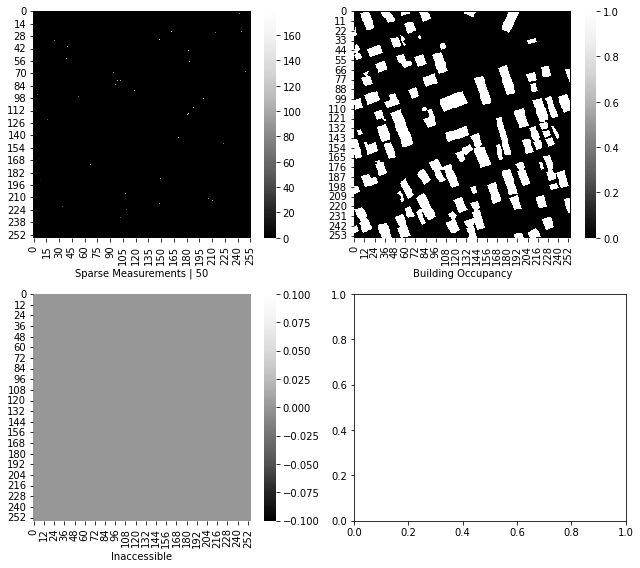

In [5]:
base_parameters = {
    'measurements' : measurements, # number of sensors measurements
    'building_signal_strength' : 0, # Put 0 for radiomapseer and -164 for wireless-insite
    'data' : 'radiomapseer', # or wireless-insite
    'map_path' : folder_path+'/png/buildings_complete',
    'blocking_radius' : blocking_radius,
    'inaccessible_path' : None, #'Inaccessible/4_stars.png' # Add the path of the drawing you would like to add.
    'shape' : 'circle', #circle or square
    # centre/inside/outside. Determine the placement of the inaccessible area.
    # centre -> Centre of the map
    # inside -> Tx is inside the inaccessible area
    # outside -> Tx is outside the inaccessible area
    'strategic_placement' : 'centre',
    'show_Tx': True, # Show Tx on the Inaccessible map | True/False 
}

if blocking_radius > 0:
    sample.generate_inaccessible_coordinates(base_parameters['blocking_radius'], shape=base_parameters['shape'], path=base_parameters['inaccessible_path'], strategic_placement=base_parameters['strategic_placement'])
sample.generate_inputs(automate=True, building_signal_strength=base_parameters['building_signal_strength'], data=base_parameters['data'], measurements=base_parameters['measurements'], map_folder=base_parameters['map_path'], inaccessible=True if blocking_radius >0 else False)

# copy the same data to the Kriging class
sample_kriging.building_coordinates = sample.building_coordinates.copy()
sample_kriging.sparsedata = sample.sparsedata.copy()
sample_kriging.true_data = sample.true_data.copy()

inaccessible = np.zeros((256,256))
if blocking_radius > 0:
    for y,x in sample.inaccessible:
        if y >= 0 and y < 256 and x >= 0 and x < 256:
            inaccessible[y,x] = 1

    # Uncomment to let Tx appear on the map.
    if base_parameters['show_Tx']:
        transmitter_coordinates = np.argwhere(
            sample.true_data == np.amax(sample.true_data))
        mean_transmitter_coordinate = (
            int(transmitter_coordinates[:, 0].mean()), int(transmitter_coordinates[:, 1].mean()))
        for y in range(mean_transmitter_coordinate[0] - 2, mean_transmitter_coordinate[0] + 2):
            for x in range(mean_transmitter_coordinate[1] - 2, mean_transmitter_coordinate[1] + 2):
                if (y-mean_transmitter_coordinate[0])**2 + (x-mean_transmitter_coordinate[1])**2 <= 2**2:
                    inaccessible[y,x] = 5

#Plotting
with plt.rc_context({
    # "figure.figsize": [9, 3.7],
    "figure.figsize": [9, 8],
    "figure.autolayout": True,
}):
    fig, ax =plt.subplots(2,2)

    sns.heatmap(sample.sparsedata, cmap='Greys_r', ax=ax[0,0]).set(xlabel=f'Sparse Measurements | {measurements}')
    sns.heatmap(sample.building_map, cmap='Greys_r', ax=ax[0,1]).set(xlabel='Building Occupancy')
    sns.heatmap(inaccessible, cmap='Greys_r', ax=ax[1,0]).set(xlabel='Inaccessible')
    plt.show()

# Run the respective REUNET and Kriging models

Edit the model_parameters if necessary

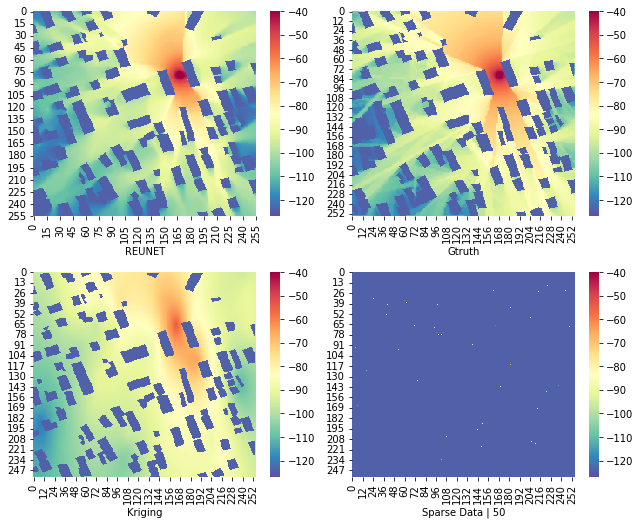


MSE Results:
REUNET - 39.10242374641288
Kriging - 71.27807225243905

SSIM Results:
REUNET - 0.8654114954167863
Kriging - 0.37974226033858455

Time Results:
REUNET - 0.8382966999999972
Kriging - 0.20946469999999806



In [6]:
model_parameters = {
    'data' : 'radiomapseer', # wireless-insite/radiomapseer
    'model' : 'exponential', # Kriging Variogram models - absoluteexponential, diraccovariance, exponential, matern, spherical, squaredexponential 
}

#Start REUNET run
reunet_time_start = perf_counter()
sample.run(data=model_parameters['data'])
reunet_time = perf_counter() - reunet_time_start

#Start Kriging run
kriging_time_start = perf_counter()
sample_kriging.secondstep(model=model_parameters['model'])
sample_kriging.output = sample_kriging.purekriging()
for y,x in sample_kriging.building_coordinates:
    sample_kriging.output[y,x] = 0
kriging_time = perf_counter() - kriging_time_start


#Plotting
with plt.rc_context({
    "figure.figsize": [9, 7.4],
    "figure.autolayout": True,
}):
    fig, ax =plt.subplots(2,2)

    sns.heatmap(sample.convert_to_pathloss(sample.get_output()), cmap='Spectral_r', ax=ax[0][0], vmax = -40, vmin=-127).set(xlabel='REUNET')
    sns.heatmap(sample.convert_to_pathloss(sample.true_data), cmap='Spectral_r', ax=ax[0][1], vmax = -40, vmin=-127).set(xlabel='Gtruth')
    sns.heatmap(sample.convert_to_pathloss(sample_kriging.get_output()), cmap='Spectral_r', ax=ax[1][0], vmax = -40, vmin=-127).set(xlabel='Kriging')
    sns.heatmap(sample.convert_to_pathloss(sample.sparsedata), cmap='Spectral_r', ax=ax[1][1], vmax = -40, vmin=-127).set(xlabel=f'Sparse Data | {base_parameters["measurements"]}')
    plt.show()

print(f'''
MSE Results:
REUNET - {sample.calculate_mse()*((99.16/255)**2)}
Kriging - {mean_squared_error(sample.convert_to_pathloss(sample_kriging.get_output()),sample.convert_to_pathloss(sample_kriging.true_data))}

SSIM Results:
REUNET - {sample.calculate_ssim()}
Kriging - {structural_similarity(sample.convert_to_pathloss(sample_kriging.get_output()),sample.convert_to_pathloss(sample_kriging.true_data))}

Time Results:
REUNET - {reunet_time}
Kriging - {kriging_time}
''')